# **Churn Prediction: Final Refined Version**
This notebook implements data preprocessing, thorough EDA, and model evaluation for churn prediction using Random Forest and XGBoost.

## **Step 1: Import Libraries**

In [121]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')



## **Step 2: Load and Inspect Data**

In [122]:

# Load dataset
data = pd.read_csv(r"C:\repos\churn_prediction\data\BankChurners.csv")


# Drop CLIENTNUM and Naive Bayes classifier columns
data.drop(columns=['CLIENTNUM', 
                   'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                   'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
          inplace=True)

# Overview
print("Data Overview:")
display(data.head())
print("Shape of data:", data.shape)
print("Null Values:")
print(data.isnull().sum())


Data Overview:


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Shape of data: (10127, 20)
Null Values:
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


## **Step 3: Encode Categorical Columns and Clean Data**

In [123]:

# Encode target variable and binary features
data['Attrition_Flag'] = data['Attrition_Flag'].replace({'Attrited Customer': 1, 'Existing Customer': 0})
data['Gender'] = data['Gender'].replace({'F': 1, 'M': 0})

# One-hot encode categorical features
categorical_cols = ['Education_Level', 'Income_Category', 'Marital_Status', 'Card_Category']
for col in categorical_cols:
    if 'Unknown' in data[col].unique():
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col).drop(columns='{}_Unknown'.format(col))], axis=1)
    else:
        data = pd.concat([data, pd.get_dummies(data[col], prefix=col)], axis=1)

# Drop original categorical columns
data.drop(columns=categorical_cols, inplace=True)
pd.set_option('display.max_columns', None)
print("Cleaned Data:")
display(data.head())
print("Updated Shape:", data.shape)


Cleaned Data:


C:\Users\petra\AppData\Local\Temp\ipykernel_50996\4110193554.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Attrition_Flag'] = data['Attrition_Flag'].replace({'Attrited Customer': 1, 'Existing Customer': 0})
C:\Users\petra\AppData\Local\Temp\ipykernel_50996\4110193554.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'] = data['Gender'].replace({'F': 1, 'M': 0})


,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,0,45,0,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,False
1,0,49,1,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,False,False,True,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False
2,0,51,0,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,False,False,True,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False
3,0,40,1,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False
4,0,40,0,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False


Updated Shape: (10127, 34)


## **Step 4: Exploratory Data Analysis**

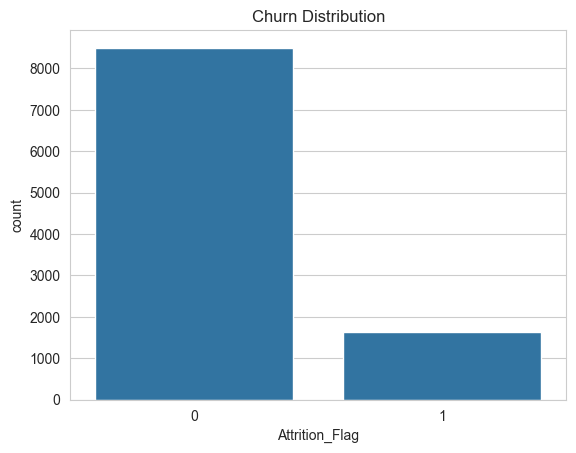

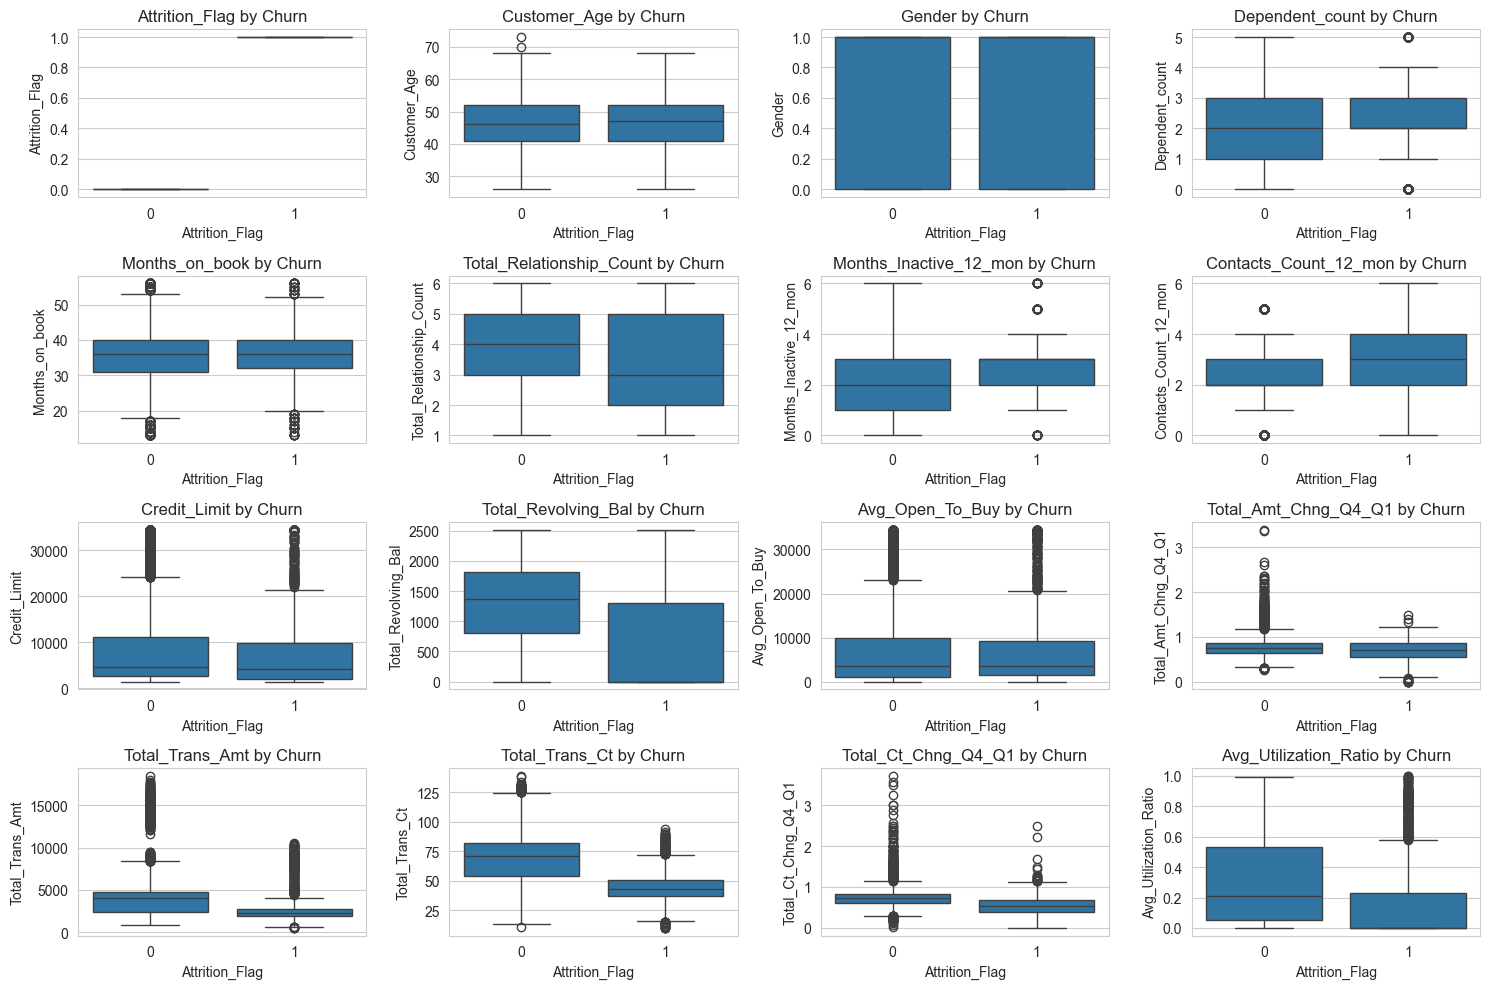

In [124]:

# Visualize class imbalance
sns.countplot(x='Attrition_Flag', data=data)
plt.title("Churn Distribution")
plt.show()

# Boxplots for numerical features to identify patterns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=data[col], x=data['Attrition_Flag'])
    plt.title(f"{col} by Churn")
plt.tight_layout()
plt.show()


## **Step 5: Train-Test Split and Class Balancing with SMOTE**

In [125]:

# Split data
X = data.drop(columns=['Attrition_Flag'])
y = data['Attrition_Flag']

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# SMOTE for imbalance handling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Class Distribution After SMOTE:")
print(y_train_res.value_counts())


Class Distribution After SMOTE:
Attrition_Flag
0    5949
1    5949
Name: count, dtype: int64


c:\repos\churn_prediction\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\repos\churn_prediction\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


## **Step 6: Random Forest Model**

In [126]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Metrics:
Accuracy: 0.94
Precision: 0.91
Recall: 0.70
F1 Score: 0.79
Confusion Matrix:
[[2519   32]
 [ 147  341]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2551
           1       0.91      0.70      0.79       488

    accuracy                           0.94      3039
   macro avg       0.93      0.84      0.88      3039
weighted avg       0.94      0.94      0.94      3039



In [127]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_res, y_train_res)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Metrics:
Accuracy: 0.94
Precision: 0.80
Recall: 0.86
F1 Score: 0.83
Confusion Matrix:
[[2443  108]
 [  66  422]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      2551
           1       0.80      0.86      0.83       488

    accuracy                           0.94      3039
   macro avg       0.88      0.91      0.90      3039
weighted avg       0.95      0.94      0.94      3039



## **Step 7: XGBoost Model**

In [137]:
xgb_model = XGBClassifier(random_state=42)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")
print("Classification Report:", classification_report(y_test, y_pred_xgb))

XGBoost Metrics:
Accuracy: 0.97
Precision: 0.92
Recall: 0.87
F1 Score: 0.90
Classification Report:               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2551
           1       0.92      0.87      0.90       488

    accuracy                           0.97      3039
   macro avg       0.95      0.93      0.94      3039
weighted avg       0.97      0.97      0.97      3039



In [138]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_xgb)

# Display confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[2516   35]
 [  62  426]]


In [130]:

xgb_model = XGBClassifier(scale_pos_weight=6, n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_res, y_train_res)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.2f}")
print("Classification Report:", classification_report(y_test, y_pred_xgb))


XGBoost Metrics:
Accuracy: 0.96
Precision: 0.84
Recall: 0.94
F1 Score: 0.88
Classification Report:               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2551
           1       0.84      0.94      0.88       488

    accuracy                           0.96      3039
   macro avg       0.91      0.95      0.93      3039
weighted avg       0.96      0.96      0.96      3039



## **Step 9: Precision/recall curve** on xgb above

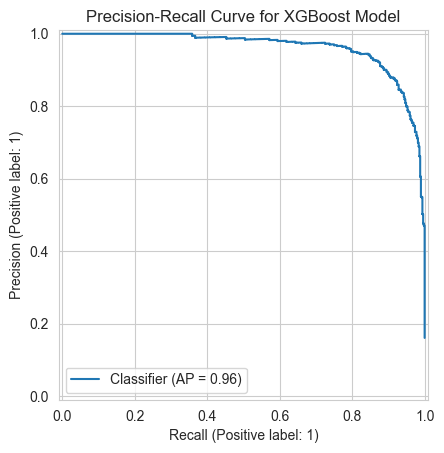

In [139]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Ensure the model is fitted
xgb_model.fit(X_train_res, y_train_res)

# Generate the ROC curve
#y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
#xgb_disp = RocCurveDisplay.from_predictions(y_test, y_pred_proba)
#plt.title("ROC Curve for XGBoost Model")
#plt.show()

# Generate the Precision-Recall curve
from sklearn.metrics import PrecisionRecallDisplay
pr_disp = PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)

# Add title and display the plot
plt.title("Precision-Recall Curve for XGBoost Model")
plt.show()


In [140]:
# Find the threshold for recall ≥ 0.9 and precision ≥ 0.5
optimal_threshold = None
for p, r, t in zip(precision, recall, thresholds):
    if r >= 0.94 and p >= 0.1:
        optimal_threshold = t
        break

if optimal_threshold is not None:
    print(f"Optimal threshold: {optimal_threshold}")
else:
    print("No threshold found that satisfies the conditions.")


Optimal threshold: 0


In [141]:
# Apply the threshold to classify customers as churners
y_pred_custom = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluate performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2551
           1       0.16      1.00      0.28       488

    accuracy                           0.16      3039
   macro avg       0.08      0.50      0.14      3039
weighted avg       0.03      0.16      0.04      3039



c:\repos\churn_prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\churn_prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\repos\churn_prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


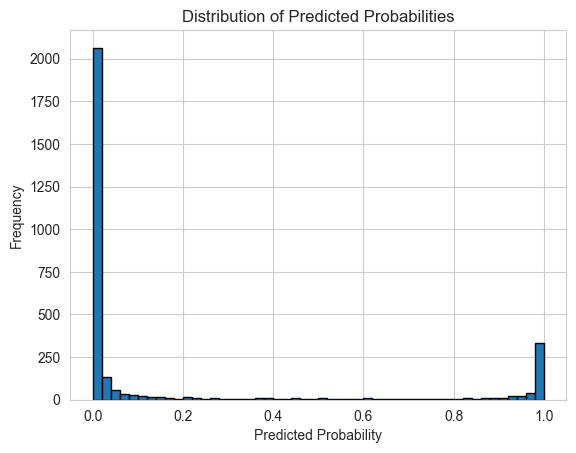

In [142]:
import matplotlib.pyplot as plt

# Visualize the distribution of predicted probabilities
plt.hist(y_pred_proba, bins=50, edgecolor='k')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


In [135]:
for p, r, t in zip(precision, recall, thresholds):
    print(f"Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}")


Threshold: 0.00, Precision: 0.16, Recall: 1.00
Threshold: 1.00, Precision: 0.84, Recall: 0.94


## **Step 8: Feature Importance** using SHAP

In [143]:
import shap

# Create a SHAP explainer for the model
explainer = shap.TreeExplainer(xgb_model)

# Explain the predictions for the dataset
shap_values = explainer.shap_values(X_test)

# Visualize feature importance summary
shap.summary_plot(shap_values, X_test)

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.

## **Step 8: Feature Importance**

In [ ]:

importances = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title("Top 10 Feature Importances")
plt.show()


## **Step 10: KNN** without balancingthe dataset

In [66]:
import sklearn
import numpy as np

In [ ]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9) 
knn.fit(X_train_scaled, y_train)

In [ ]:
# Evaluate your model
y_pred = knn.predict(X_test_scaled)
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
k_values = range(1, 21)  # Test K values from 1 to 20
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    accuracy = knn.score(X_test_scaled, y_test)
    accuracies.append(accuracy)

# Plot accuracy vs K
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies, marker='o', color='b')
plt.title('Accuracy vs K for KNN Classifier')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Find the best K
best_k = k_values[accuracies.index(max(accuracies))]
print(f"The best value of K is {best_k} with an accuracy of {max(accuracies):.2f}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
print("Confusion Matrix:")
print(cm)

## **Step 10: KNN** with balancing the dataset

In [ ]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=12) 
knn.fit(X_train_scaled_res, y_train_res)

In [ ]:
# Evaluate your model
y_pred = knn.predict(X_test_scaled)
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
k_values = range(1, 21)  # Test K values from 1 to 20
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(X_train_scaled_res, y_train_res)
    y_pred = knn.predict(X_test_scaled)
    accuracy = knn.score(X_test_scaled, y_test)
    accuracies.append(accuracy)

# Plot accuracy vs K
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracies, marker='o', color='b')
plt.title('Accuracy vs K for KNN Classifier')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Find the best K
best_k = k_values[accuracies.index(max(accuracies))]
print(f"The best value of K is {best_k} with an accuracy of {max(accuracies):.2f}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
print("Confusion Matrix:")
print(cm)